In [44]:
#MAke more use of the markdowns and give a proper intro here.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from random import choice, sample, random
from IPython.display import clear_output
import copy

In [3]:
%matplotlib inline

In [4]:
def sigmoid(x):
    '''Function definition for the purpose of SA. 
    This is an alternative to the originally proposed
    Bolztmann distribution function in the Metropolis-Hastings
    algo.'''
    return 1/(1+ np.exp(x))

In [5]:
def distance(coords):
    '''Takes in an array of the co-ordinates of the cities and 
    returns the Euclidean distance of the path for the given permutation.'''
    dist=0
    for i in range(len(coords)-1):
        dist+= np.sqrt(np.sum(np.square(coords[i,]- coords[i+1,])))
#         print(i)
    dist+= np.sqrt(np.sum(np.square(coords[0,]- coords[-1,])))
    return dist

In [6]:
def distance_abs(coords):
    '''Takes in an array of the co-ordinates of the cities and 
    returns the Manhattan distance of the path for the given permutation.'''
    dist=0
    for i in range(len(coords)-1):
        dist+= np.sum(np.abs(coords[i,]- coords[i+1,]))
#         print(i)
    dist+= np.sum(np.abs(coords[0,]- coords[-1,]))
    return dist

In [7]:
def get_sample(cities, undo_index= None, undo= False):
    '''Takes in two random sets of co-ordinates and swaps them to generate
    a new solution. The indices are kept track of to undo a change.'''
    index=[]
    if not undo:
        index= sample(range(0, len(cities)), 2)
        cities[[index[0], index[1]]]= cities[[index[1], index[0]]]
    else:
        cities[[undo_index[0], undo_index[1]]]= cities[[undo_index[1], undo_index[0]]]
    return cities, index

In [8]:
def get_sample_rev(cities, undo_index= None, undo= False):
    '''A more complex and better strategy to generate a new solution. The function takes
    in a section of cities and reverses the direction in which they are arranged(travelled).'''
    index=[]
    if not undo:
        index= sample(range(0, len(cities)), 2)
        cities[min(index):max(index),]=cities[min(index):max(index),][::-1]
    else:
        cities[min(undo_index):max(undo_index),]=cities[min(undo_index):max(undo_index),][::-1]
    return cities, index

In [9]:
def create_circle(N_cities, r= 0.5):
    '''Creates a random arrangement of a given number of points on a circle of a given radius.'''
    X=[]
    Y=[]
    for i in range(N_cities):
        theta= 2*np.pi*np.random.rand()
        x= r*np.cos(theta)
        y= r*np.sin(theta)
        X.append(x)
        Y.append(y)
    X=np.array(X).reshape((N_cities,1))
    Y=np.array(Y).reshape((N_cities,1))
    cities= np.concatenate((X,Y), axis=1)
    return cities

In [10]:
def get_temperature(cities, scale= 2):
    '''Function to set up the initial temperature of the system. The maximum distance 
    found in a few random solutions is scaled by a given factor.'''
    delta_E=[]
    for i in range(150):
        distance= distance_abs(cities)
        citi, ind= get_sample_rev(cities)
        diff= distance_abs(citi)- distance
        delta_E.append(np.abs(diff))
    return scale*max(delta_E)

In [28]:
def traveling_salesman_greedy(cities, lim=300):
    '''A greedy algorithm that only accepts the good solutions as they are
    generated. A bad solution is not accepted and the changes made are undone.
    Plotting is done in real time to get an intuition. The other strategy can be
    commented out for comparison. Additionally, the plotting portion can be commented
    to look at just the final result.'''
    dist= distance_abs(cities)
    dist_new=[]
    i=0
    while True:
        new_cities, ind= get_sample_rev(cities)  #Generating the sample solutions. 
#         new_cities, ind= get_sample(cities)    #Alternate strategy
        if distance_abs(new_cities)< dist:
            dist= distance_abs(new_cities)
            dist_new.append(dist)
            #plotting
            clear_output(wait=True) #clear the previous plot to show the new solution.
            plt.figure(figsize=(12,6))
            plt.plot(new_cities[:,0], new_cities[:,1], marker= 'o',mfc= 'pink',mew=1.5,c='black', label=f'dist :{dist}')
            plt.plot(new_cities[[0,-1]][:,0], new_cities[[0,-1]][:,1], marker= 'o',mfc= 'pink',mew=1.5,c='black')
            plt.legend()
            plt.show()
        else:                            #To undo the unsuccessful change made earlier
            dist_new.append(dist)
            get_sample_rev(cities,undo_index= ind, undo= True)
#             get_sample(cities,undo_index= ind, undo= True)
        if dist_new[-lim:].count(dist)== lim: #The loop is stopped when the solution does not improve for 'lim' no. of iterations.
            print('Exit loop :',i)
            break
        i+=1
    return dist, new_cities

In [30]:
def traveling_salesman_SA(cities, alpha=0.9, N_out=100, N_in=50, lim=300):
    '''The Simulated annealing method applied to the Traveling salesman problem.
    The system starts at a high temperature and accepts solutions based on the Metropolis
    alogorithm. The temperature is cooled down at a rate alpha. The function returns the
    optimal distance obtained, the corresponding arrangement of cities, the specfic heat
    variation and the temperature variation with the iterations.
    
    N_out is the number of iterations through which the temperature is reduced. N_in is
    the number of iterations for which the annealing occurs at a particular temperature.
    alpha, N_out, N_in and the initial temperature constiture the annealing schedule.
    lim decides the when the loops break. A sudden change in the specific heat is indicative
    of a phase tansition which can be used to stop/slow down the cooling.'''
    dist_new=[]
    cv=[]
    cv_list= []
    exit= False
    temp=[]
    dist= distance_abs(cities)
    T= get_temperature(cities, scale= 1)   #To determine the initial temperature.
    for i in range(N_out):
        for j in range(N_in):
            new_cities, ind= get_sample_rev(cities)
            del_E= distance_abs(new_cities)- dist
            if del_E<0:
                #Update
                dist= distance_abs(new_cities)
                dist_new.append(dist)
                cv_list.append(dist)
            #plotting
                clear_output(wait=True)  #clear the previous plot to show the new solution.
                plt.figure(figsize=(12,6))
                plt.plot(new_cities[:,0], new_cities[:,1], marker= 'o',mfc= 'pink',mew=1.5,c='black', label=f'dist :{"{:.2f}".format(dist)}')
                plt.plot(new_cities[[0,-1]][:,0], new_cities[[0,-1]][:,1], marker= 'o',mfc= 'pink',mew=1.5,c='black', label=f'Temp:{"{:.2f}".format(T)}')
                plt.legend()
                plt.show()
            else:
                P= np.exp(-del_E/T)
                rand= np.random.uniform()
                if rand<= P:
                    dist= distance_abs(new_cities)
                    dist_new.append(dist)
                    cv_list.append(dist)
                else:                            #To undo the unsuccessful change made earlier
                    dist_new.append(dist)
                    get_sample_rev(cities,undo_index= ind, undo= True)
#                     get_sample(cities,undo_index= ind, undo= True)
            #Larger number of cities need a larger threshold.
            if dist_new[-lim:].count(dist)== lim:
                exit= True
                print('Exit loop: ',(i,j))
                break
        if exit:
            break
        cv.append(np.var(cv_list)/(T**2))
        cv_list=[]
        temp.append(T)
        T= alpha*T
#     plt.plot(temp, cv)
#     plt.show()
    return dist, new_cities, cv, temp

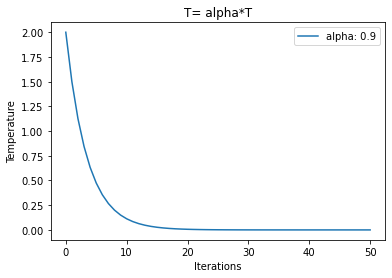

In [17]:
#To determine alpha by trial and error.
# T= get_temperature(cities,50)
T=2
a=[T]
for i in range(50):
    T= 0.75*T
    a.append(T)
plt.plot(a, label='alpha: 0.9')
plt.title("T= alpha*T")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Temperature")
plt.savefig("temp_1")
plt.show()

# Implementation

In [41]:
# cities= np.random.random((20,2))  #To get a random arrangement of cities.
cities= create_circle(20)           #To generate a circular/oval arrangement of cities.

### The annealing schedule is highly crucial for a good result in SA. Notice how the distance ocassionally increases. 

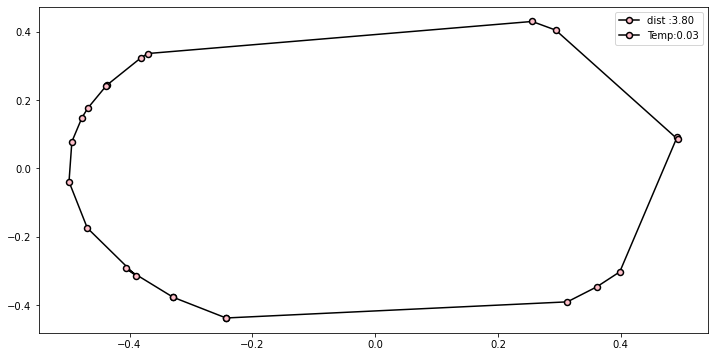

Exit loop:  (21, 15)


In [42]:
test_cities= copy.deepcopy(cities) #To maintain a copy of the initial arrangement for the greedy algorithm.
length, citi, CV, temp= traveling_salesman_SA(cities,0.80,50,50, 100) 

# If only the result is needed:
# plt.figure(figsize=(12,6))
# plt.plot(citi[:,0], citi[:,1], marker= 'o',mfc= 'pink',mew=1.5, c='black', label=f'dist :{"{:.2f}".format(length)}')
# plt.plot(citi[[0,-1]][:,0], citi[[0,-1]][:,1], marker= 'o',mfc= 'pink',mew=1.5, c='black')
# plt.legend()
# plt.savefig("Filename")

Text(0, 0.5, 'Temperature')

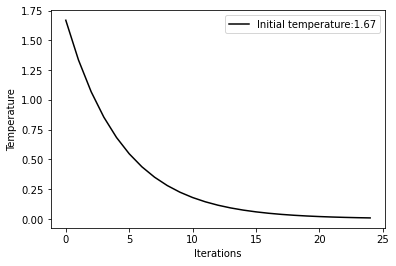

In [20]:
plt.plot(temp, label=f'Initial temperature:{"{:.2f}".format(temp[0])}', c='black')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Temperature")
# plt.savefig('temp')

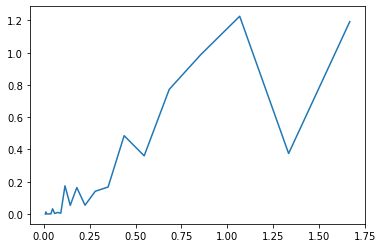

In [21]:
cv, T= np.array(CV), np.array(temp)
var= cv*(T**2)
plt.plot(T, var)

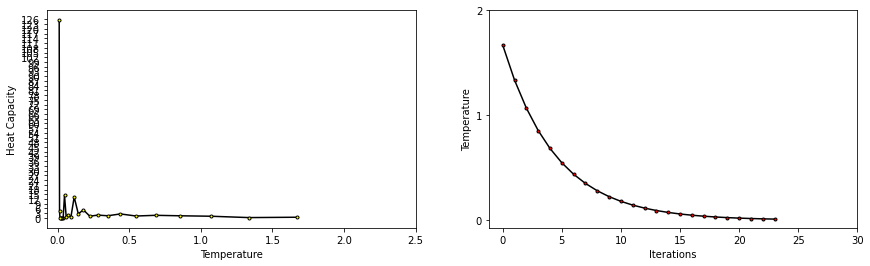

<Figure size 432x288 with 0 Axes>

In [25]:
#An optional plotting section for the purpose of presentation.
for i in range(len(cv)):
    clear_output(wait=True)
    plt.subplot(1,2,1)
    plt.subplots_adjust(right= 2)
    plt.plot(temp[:i], cv[:i], marker='o',mfc='yellow',c='black',markersize=3)
    plt.xticks(np.arange(0,3,0.5))             #Needs to be changes based on the particular array range.
    plt.yticks(np.arange(0,max(cv)+3,3)) 
    plt.xlabel('Temperature')
    plt.ylabel('Heat Capacity')
    plt.subplot(1,2,2)
    plt.plot(temp[:i], marker='o',mfc='red', c='black',markersize=3)
    plt.yticks(np.arange(0,3))
    plt.xticks(np.arange(0,35,5))             #Needs to be changes based on the particular array range.   
    plt.xlabel('Iterations')
    plt.ylabel('Temperature')
    plt.pause(0.2)
    plt.show()
    plt.tight_layout()

### Notice that distance in the greedy algorithm strictly decreases in contrast to the SA algorithm.

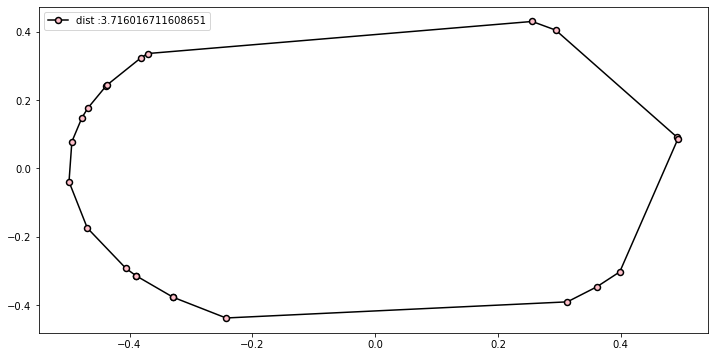

Exit loop : 2060


In [43]:
length, citi= traveling_salesman_greedy(test_cities, 1500) 

# If only the result is needed:
# plt.figure(figsize=(12,6))
# plt.plot(citi[:,0], citi[:,1], marker= 'o',mfc= 'pink',mew=1.5, c='black', label=f'Distance :{length}')
# plt.plot(citi[[0,-1]][:,0], citi[[0,-1]][:,1], marker= 'o',mfc= 'pink',mew=1.5, c='black')
# plt.legend()
# plt.savefig("Greedy")